# Understanding Catastrophic Forgetting

In [85]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 281 kB 38.0 MB/s eta 0:00:01
     |████████████████████████████████| 145 kB 44.3 MB/s eta 0:00:01
     |████████████████████████████████| 661 kB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.1 MB/s  eta 0:00:01
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8784 sha256=197f4f2e2da630d86c5160a310be5d4fe4f865048710162412d2451b6f7a0bc4
  Stored in directory: /home/sawant_shriraj/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [86]:
from wandb import magic

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/sawant_shriraj/.netrc


# Overcoming Catastrophic Forgetting

https://arxiv.org/abs/1612.00796

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import Regularizer

tf.compat.v1.disable_eager_execution()

def computer_fisher(model, imgset, num_sample=30):
    f_accum = []
    for i in range(len(model.weights)):
        f_accum.append(np.zeros(K.int_shape(model.weights[i])))
    f_accum = np.array(f_accum)
    for j in range(num_sample):
        img_index = np.random.randint(imgset.shape[0])
        for m in range(len(model.weights)):                           
            grads = K.gradients(K.log(model.output), model.weights)[m]
            result = K.function([model.input], [grads])
            f_accum[m] += np.square(result([np.expand_dims(imgset[img_index], 0)])[0])
    f_accum /= num_sample
    return f_accum


class ewc_reg(Regularizer):
    def __init__(self, fisher, prior_weights, Lambda=0.1):
        self.fisher = fisher
        self.prior_weights = prior_weights
        self.Lambda = Lambda

    def __call__(self, x):
        regularization = 0.
        regularization += self.Lambda * K.sum(self.fisher * K.square(x - self.prior_weights))
        return regularization

    def get_config(self):
        return {'Lambda': float(self.Lambda)}

2022-07-13 22:43:41.740630: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


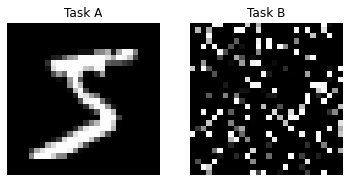

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Random pixel permutation for Task B
ind = np.arange(x_train.shape[1])
np.random.shuffle(ind)
x_train1 = x_train[:, ind]
x_test1 = x_test[:, ind]
y_train1 = y_train
y_test1 = y_test

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [3]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('MNISTA.h5')


Train on 60000 samples, validate on 10000 samples


2022-07-06 15:29:18.060461: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-06 15:29:18.061857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-06 15:29:18.131618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-07-06 15:29:18.132946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-07-06 15:29:18.132983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-06 15

Epoch 1/10
58300/60000 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.9088

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 26us/sample - loss: 0.3303 - accuracy: 0.9098 - val_loss: 0.1698 - val_accuracy: 0.9519
Epoch 2/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1479 - accuracy: 0.9571 - val_loss: 0.1244 - val_accuracy: 0.9642
Epoch 3/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1041 - accuracy: 0.9699 - val_loss: 0.1002 - val_accuracy: 0.9695
Epoch 4/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0808 - accuracy: 0.9766 - val_loss: 0.0889 - val_accuracy: 0.9737
Epoch 5/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0643 - accuracy: 0.9811 - val_loss: 0.0745 - val_accuracy: 0.9771
Epoch 6/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0523 - accuracy: 0.9845 - val_loss: 0.0723 - val_accuracy: 0.9774
Epoch 7/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0437 - accuracy: 0.9875 - val_loss

In [21]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3703270/1809107757.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [22]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(10, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.6218 - accuracy: 0.8413 - val_loss: 0.2769 - val_accuracy: 0.9244
Epoch 2/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.2346 - accuracy: 0.9391 - val_loss: 0.1996 - val_accuracy: 0.9447
Epoch 3/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1758 - accuracy: 0.9538 - val_loss: 0.1694 - val_accuracy: 0.9531
Epoch 4/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1425 - accuracy: 0.9627 - val_loss: 0.1499 - val_accuracy: 0.9600
Epoch 5/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1219 - accuracy: 0.9688 - val_loss: 0.1376 - val_accuracy: 0.9612
Epoch 6/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1071 - accuracy: 0.9724 - val_loss: 0.1214 - val_accuracy: 0.9660
Epoch 7/10
60000/60000 [==============================] 

In [23]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(10, activation='softmax'))
model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.4755 - accuracy: 0.8661 - val_loss: 0.1863 - val_accuracy: 0.9449
Epoch 2/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1537 - accuracy: 0.9546 - val_loss: 0.1287 - val_accuracy: 0.9617
Epoch 3/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1068 - accuracy: 0.9684 - val_loss: 0.1070 - val_accuracy: 0.9668
Epoch 4/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0816 - accuracy: 0.9761 - val_loss: 0.0918 - val_accuracy: 0.9717
Epoch 5/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0645 - accuracy: 0.9811 - val_loss: 0.0857 - val_accuracy: 0.9741
Epoch 6/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0514 - accuracy: 0.9853 - val_loss: 0.0834 - val_accuracy: 0.9749
Epoch 7/10
60000/60000 [==============================] 

In [24]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 97.81%
Task B EWC method penalty Accuracy: 97.08%
Task B SGD method Accuracy: 97.81%
Task A EWC method penalty Accuracy: 97.66%
Task A SGD method Accuracy: 69.62%


/tmp/ipykernel_3703270/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

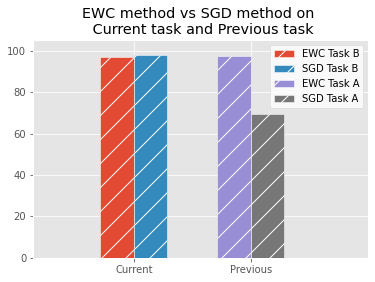

In [25]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

In [ ]:
# swap task A and B

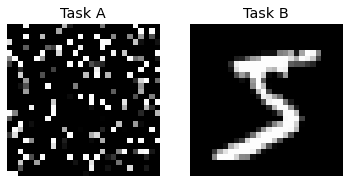

In [78]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

# Original MNIST for Task B
x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# Random pixel permutation for Task A
ind = np.arange(x_train.shape[1])
np.random.shuffle(ind)
x_train = x_train1[:, ind]
x_test = x_test1[:, ind]
y_train = y_train1
y_test = y_test1

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [79]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('randMNISTA.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
58600/60000 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.9062

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 40us/sample - loss: 0.3311 - accuracy: 0.9071 - val_loss: 0.1867 - val_accuracy: 0.9450
Epoch 2/10
60000/60000 [==============================] - 2s 34us/sample - loss: 0.1546 - accuracy: 0.9561 - val_loss: 0.1304 - val_accuracy: 0.9629
Epoch 3/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.1096 - accuracy: 0.9684 - val_loss: 0.1018 - val_accuracy: 0.9711
Epoch 4/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0842 - accuracy: 0.9759 - val_loss: 0.0918 - val_accuracy: 0.9726
Epoch 5/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0686 - accuracy: 0.9802 - val_loss: 0.0805 - val_accuracy: 0.9752
Epoch 6/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0555 - accuracy: 0.9834 - val_loss: 0.0813 - val_accuracy: 0.9745
Epoch 7/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0457 - accuracy: 0.9869 - val_loss

In [80]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3703270/1809107757.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [81]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(10, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('randMNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.5940 - accuracy: 0.8468 - val_loss: 0.2767 - val_accuracy: 0.9263
Epoch 2/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2310 - accuracy: 0.9379 - val_loss: 0.1968 - val_accuracy: 0.9435
Epoch 3/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1740 - accuracy: 0.9535 - val_loss: 0.1586 - val_accuracy: 0.9535
Epoch 4/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.1424 - accuracy: 0.9625 - val_loss: 0.1434 - val_accuracy: 0.9583
Epoch 5/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.1226 - accuracy: 0.9675 - val_loss: 0.1318 - val_accuracy: 0.9616
Epoch 6/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1070 - accuracy: 0.9719 - val_loss: 0.1198 - val_accuracy: 0.9647
Epoch 7/10
60000/60000 [==============================] 

In [82]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(10, activation='softmax'))
model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('randMNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.4579 - accuracy: 0.8678 - val_loss: 0.1834 - val_accuracy: 0.9462
Epoch 2/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1523 - accuracy: 0.9554 - val_loss: 0.1317 - val_accuracy: 0.9599
Epoch 3/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1064 - accuracy: 0.9693 - val_loss: 0.1092 - val_accuracy: 0.9679
Epoch 4/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0818 - accuracy: 0.9757 - val_loss: 0.1018 - val_accuracy: 0.9693
Epoch 5/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0645 - accuracy: 0.9807 - val_loss: 0.0907 - val_accuracy: 0.9736
Epoch 6/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0518 - accuracy: 0.9854 - val_loss: 0.0848 - val_accuracy: 0.9749
Epoch 7/10
60000/60000 [==============================] 

In [83]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 97.80%
Task B EWC method penalty Accuracy: 97.18%
Task B SGD method Accuracy: 97.62%
Task A EWC method penalty Accuracy: 97.33%
Task A SGD method Accuracy: 74.17%


/tmp/ipykernel_3703270/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

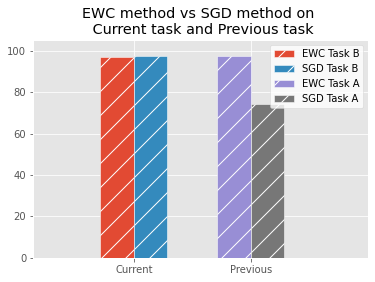

In [84]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

## With mnist first and fmnist as sequential task

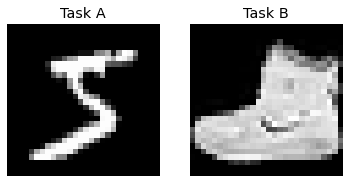

In [26]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))


#FMNIST for task B

(x_train1, y_train1), (x_test1, y_test1) = fashion_mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [27]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('MNISTA.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
58000/60000 [============================>.] - ETA: 0s - loss: 0.3384 - accuracy: 0.9059

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 1s 25us/sample - loss: 0.3331 - accuracy: 0.9074 - val_loss: 0.1865 - val_accuracy: 0.9458
Epoch 2/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.1569 - accuracy: 0.9552 - val_loss: 0.1279 - val_accuracy: 0.9635
Epoch 3/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.1104 - accuracy: 0.9685 - val_loss: 0.1043 - val_accuracy: 0.9686
Epoch 4/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0837 - accuracy: 0.9758 - val_loss: 0.1003 - val_accuracy: 0.9704
Epoch 5/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0671 - accuracy: 0.9803 - val_loss: 0.0894 - val_accuracy: 0.9747
Epoch 6/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0550 - accuracy: 0.9836 - val_loss: 0.0807 - val_accuracy: 0.9754
Epoch 7/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0455 - accuracy: 0.9864 - val_loss

In [28]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3703270/1809107757.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [29]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(10, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 32us/sample - loss: 1.3825 - accuracy: 0.7123 - val_loss: 0.7672 - val_accuracy: 0.7829
Epoch 2/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.6548 - accuracy: 0.8064 - val_loss: 0.6241 - val_accuracy: 0.8104
Epoch 3/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.5636 - accuracy: 0.8254 - val_loss: 0.5692 - val_accuracy: 0.8221
Epoch 4/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.5112 - accuracy: 0.8381 - val_loss: 0.5593 - val_accuracy: 0.8217
Epoch 5/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.4767 - accuracy: 0.8468 - val_loss: 0.5062 - val_accuracy: 0.8352
Epoch 6/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.4487 - accuracy: 0.8526 - val_loss: 0.5193 - val_accuracy: 0.8313
Epoch 7/10
60000/60000 [==============================] 

In [30]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(10, activation='softmax'))
model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.9274 - accuracy: 0.7502 - val_loss: 0.5342 - val_accuracy: 0.8131
Epoch 2/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.4389 - accuracy: 0.8456 - val_loss: 0.4458 - val_accuracy: 0.8459
Epoch 3/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.3793 - accuracy: 0.8644 - val_loss: 0.4038 - val_accuracy: 0.8597
Epoch 4/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.3510 - accuracy: 0.8748 - val_loss: 0.4009 - val_accuracy: 0.8581
Epoch 5/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.3260 - accuracy: 0.8820 - val_loss: 0.3805 - val_accuracy: 0.8633
Epoch 6/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.3076 - accuracy: 0.8898 - val_loss: 0.3776 - val_accuracy: 0.8657
Epoch 7/10
60000/60000 [==============================] 

In [53]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 97.64%
Task B EWC method penalty Accuracy: 85.47%
Task B SGD method Accuracy: 87.85%
Task A EWC method penalty Accuracy: 95.38%
Task A SGD method Accuracy: 29.77%


10000

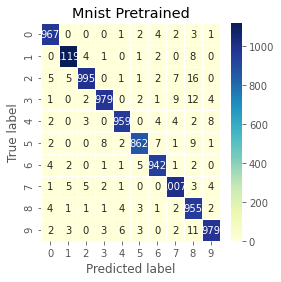

In [48]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

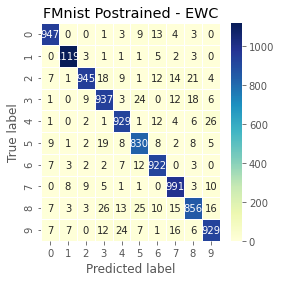

In [74]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

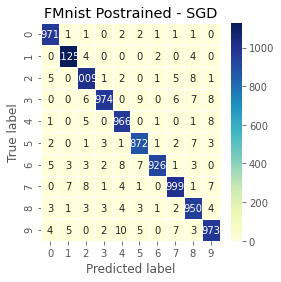

In [75]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

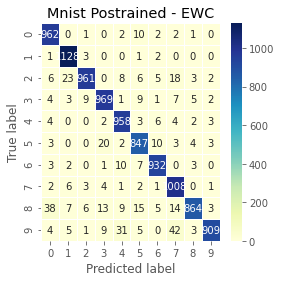

In [54]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

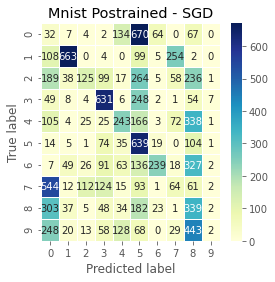

In [55]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/tmp/ipykernel_3703270/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

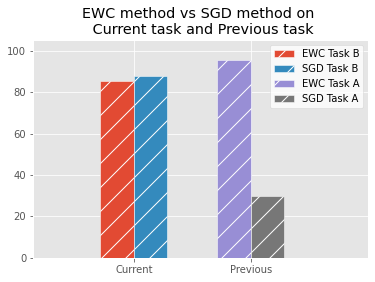

In [32]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

## With fmnist first and mnist as sequential task

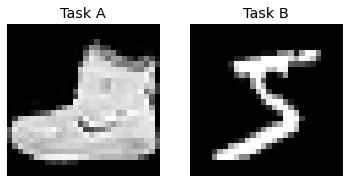

In [57]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))


#MNIST for task B

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [58]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('FMNISTA.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
58500/60000 [============================>.] - ETA: 0s - loss: 0.5472 - accuracy: 0.8097

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 28us/sample - loss: 0.5446 - accuracy: 0.8105 - val_loss: 0.4687 - val_accuracy: 0.8291
Epoch 2/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.4004 - accuracy: 0.8590 - val_loss: 0.4126 - val_accuracy: 0.8553
Epoch 3/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.3611 - accuracy: 0.8709 - val_loss: 0.4009 - val_accuracy: 0.8574
Epoch 4/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3365 - accuracy: 0.8783 - val_loss: 0.3711 - val_accuracy: 0.8646
Epoch 5/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3145 - accuracy: 0.8870 - val_loss: 0.3645 - val_accuracy: 0.8724
Epoch 6/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3043 - accuracy: 0.8888 - val_loss: 0.3615 - val_accuracy: 0.8704
Epoch 7/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2892 - accuracy: 0.8949 - val_loss

In [59]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3703270/1809107757.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [60]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(10, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('FMNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 34us/sample - loss: 0.9382 - accuracy: 0.8137 - val_loss: 0.5254 - val_accuracy: 0.8880
Epoch 2/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4342 - accuracy: 0.9024 - val_loss: 0.3695 - val_accuracy: 0.9109
Epoch 3/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.3465 - accuracy: 0.9173 - val_loss: 0.3196 - val_accuracy: 0.9217
Epoch 4/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3047 - accuracy: 0.9265 - val_loss: 0.2910 - val_accuracy: 0.9293
Epoch 5/10
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2822 - accuracy: 0.9315 - val_loss: 0.2727 - val_accuracy: 0.9349
Epoch 6/10
60000/60000 [==============================] - 1s 25us/sample - loss: 0.2670 - accuracy: 0.9359 - val_loss: 0.2620 - val_accuracy: 0.9355
Epoch 7/10
60000/60000 [==============================] 

In [61]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(10, activation='softmax'))
model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('FMNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.4538 - accuracy: 0.8760 - val_loss: 0.1787 - val_accuracy: 0.9467
Epoch 2/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.1525 - accuracy: 0.9554 - val_loss: 0.1307 - val_accuracy: 0.9608
Epoch 3/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1077 - accuracy: 0.9682 - val_loss: 0.1101 - val_accuracy: 0.9658
Epoch 4/10
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0832 - accuracy: 0.9754 - val_loss: 0.0949 - val_accuracy: 0.9721
Epoch 5/10
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0652 - accuracy: 0.9811 - val_loss: 0.0871 - val_accuracy: 0.9735
Epoch 6/10
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0536 - accuracy: 0.9844 - val_loss: 0.0856 - val_accuracy: 0.9744
Epoch 7/10
60000/60000 [==============================] 

In [62]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 87.94%
Task B EWC method penalty Accuracy: 94.05%
Task B SGD method Accuracy: 97.65%
Task A EWC method penalty Accuracy: 35.20%
Task A SGD method Accuracy: 22.07%


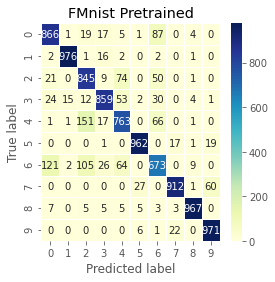

In [69]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

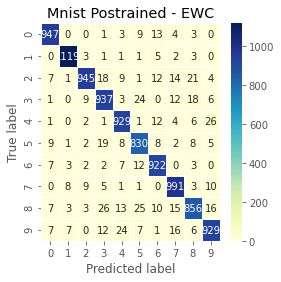

In [76]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

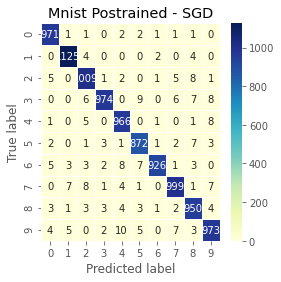

In [77]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

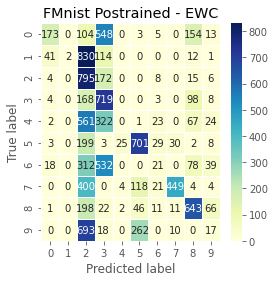

In [72]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

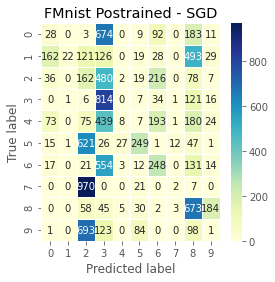

In [73]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/tmp/ipykernel_3703270/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3703270/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

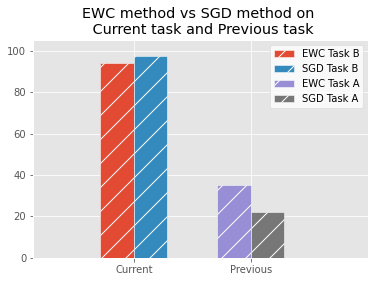

In [68]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

# Extended labels (one to one)

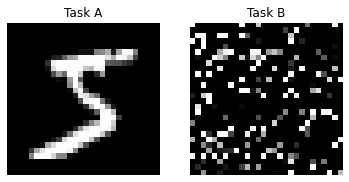

In [23]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Random pixel permutation for Task B
ind = np.arange(x_train.shape[1])
np.random.shuffle(ind)
x_train1 = x_train[:, ind]
x_test1 = x_test[:, ind]
y_train1 = y_train[:]
y_test1 = y_test[:]

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [24]:
from tensorflow import keras
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)

In [25]:
print(y_train1[2])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [26]:
import numpy as np

for i in range(10):
    y_train = np.hstack((y_train, np.zeros((len(y_train),1))))
    y_test = np.hstack((y_test, np.zeros((len(y_test),1))))
    y_train1 = np.hstack((y_train1, np.zeros((len(y_train1),1))))
    y_test1 = np.hstack((y_test1, np.zeros((len(y_test1),1))))

In [27]:
print(y_train1[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(20, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('MNISTA.h5')


Train on 60000 samples, validate on 10000 samples


2022-07-13 23:05:20.135839: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-13 23:05:20.137237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-13 23:05:20.170150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-07-13 23:05:20.170862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-07-13 23:05:20.170885: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-13 23

Epoch 1/10


2022-07-13 23:05:21.528162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


60000/60000 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8994

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 32us/sample - loss: 0.3633 - accuracy: 0.8994 - val_loss: 0.2071 - val_accuracy: 0.9390
Epoch 2/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.1657 - accuracy: 0.9517 - val_loss: 0.1430 - val_accuracy: 0.9581
Epoch 3/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.1177 - accuracy: 0.9657 - val_loss: 0.1189 - val_accuracy: 0.9650
Epoch 4/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0903 - accuracy: 0.9736 - val_loss: 0.1017 - val_accuracy: 0.9696
Epoch 5/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0729 - accuracy: 0.9795 - val_loss: 0.0911 - val_accuracy: 0.9726
Epoch 6/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0590 - accuracy: 0.9827 - val_loss: 0.0923 - val_accuracy: 0.9732
Epoch 7/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0487 - accuracy: 0.9858 - val_loss

In [31]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3821533/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [32]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(20, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.7100 - accuracy: 0.8245 - val_loss: 0.3002 - val_accuracy: 0.9227
Epoch 2/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.2511 - accuracy: 0.9331 - val_loss: 0.2155 - val_accuracy: 0.9419
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1884 - accuracy: 0.9494 - val_loss: 0.1772 - val_accuracy: 0.9528
Epoch 4/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1553 - accuracy: 0.9588 - val_loss: 0.1595 - val_accuracy: 0.9592
Epoch 5/10
60000/60000 [==============================] - 2s 40us/sample - loss: 0.1332 - accuracy: 0.9646 - val_loss: 0.1450 - val_accuracy: 0.9615
Epoch 6/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1172 - accuracy: 0.9698 - val_loss: 0.1346 - val_accuracy: 0.9641
Epoch 7/10
60000/60000 [==============================] 

In [35]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(20, activation='softmax'))
model_NoP_B.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.5172 - accuracy: 0.8567 - val_loss: 0.1946 - val_accuracy: 0.9430
Epoch 2/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1610 - accuracy: 0.9524 - val_loss: 0.1379 - val_accuracy: 0.9593
Epoch 3/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.1133 - accuracy: 0.9667 - val_loss: 0.1159 - val_accuracy: 0.9655
Epoch 4/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0882 - accuracy: 0.9742 - val_loss: 0.0994 - val_accuracy: 0.9694
Epoch 5/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0693 - accuracy: 0.9801 - val_loss: 0.0979 - val_accuracy: 0.9699
Epoch 6/10
60000/60000 [==============================] - 2s 34us/sample - loss: 0.0565 - accuracy: 0.9835 - val_loss: 0.0902 - val_accuracy: 0.9712
Epoch 7/10
60000/60000 [==============================] 

In [36]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 97.46%
Task B EWC method penalty Accuracy: 96.96%
Task B SGD method Accuracy: 97.61%
Task A EWC method penalty Accuracy: 97.21%
Task A SGD method Accuracy: 79.44%


/tmp/ipykernel_3821533/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

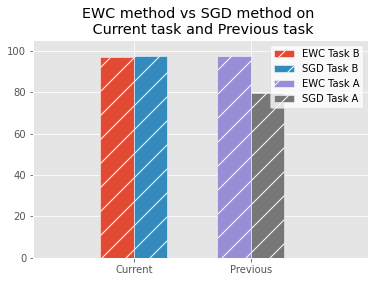

In [37]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

In [ ]:
# swap task A and B

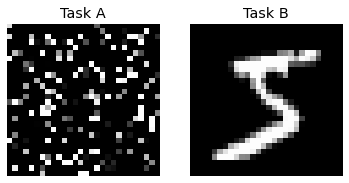

In [38]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

# Original MNIST for Task B
x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# Random pixel permutation for Task A
ind = np.arange(x_train.shape[1])
np.random.shuffle(ind)
x_train = x_train1[:, ind]
x_test = x_test1[:, ind]
y_train = y_train1
y_test = y_test1

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [39]:
from tensorflow import keras
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)

In [40]:
print(y_train1[2])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [41]:
import numpy as np

for i in range(10):
    y_train = np.hstack((y_train, np.zeros((len(y_train),1))))
    y_test = np.hstack((y_test, np.zeros((len(y_test),1))))
    y_train1 = np.hstack((y_train1, np.zeros((len(y_train1),1))))
    y_test1 = np.hstack((y_test1, np.zeros((len(y_test1),1))))

In [42]:
print(y_train1[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [43]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(20, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('randMNISTA.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59400/60000 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.9015

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 37us/sample - loss: 0.3571 - accuracy: 0.9021 - val_loss: 0.1862 - val_accuracy: 0.9486
Epoch 2/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1619 - accuracy: 0.9534 - val_loss: 0.1306 - val_accuracy: 0.9605
Epoch 3/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1150 - accuracy: 0.9662 - val_loss: 0.1078 - val_accuracy: 0.9674
Epoch 4/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0895 - accuracy: 0.9742 - val_loss: 0.0955 - val_accuracy: 0.9710
Epoch 5/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0726 - accuracy: 0.9786 - val_loss: 0.0902 - val_accuracy: 0.9739
Epoch 6/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0597 - accuracy: 0.9822 - val_loss: 0.0832 - val_accuracy: 0.9747
Epoch 7/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0492 - accuracy: 0.9856 - val_loss

In [44]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3821533/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [45]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(20, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 34us/sample - loss: 723.6100 - accuracy: 0.9626 - val_loss: 163.7686 - val_accuracy: 0.9335
Epoch 2/10
60000/60000 [==============================] - 2s 31us/sample - loss: 60.5297 - accuracy: 0.9379 - val_loss: 12.4812 - val_accuracy: 0.9424
Epoch 3/10
60000/60000 [==============================] - 2s 30us/sample - loss: 4.1396 - accuracy: 0.9506 - val_loss: 0.7257 - val_accuracy: 0.9501
Epoch 4/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.2960 - accuracy: 0.9599 - val_loss: 0.1688 - val_accuracy: 0.9569
Epoch 5/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1290 - accuracy: 0.9656 - val_loss: 0.1403 - val_accuracy: 0.9612
Epoch 6/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1105 - accuracy: 0.9708 - val_loss: 0.1359 - val_accuracy: 0.9645
Epoch 7/10
60000/60000 [==========================

In [46]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(20, activation='softmax'))
model_NoP_B.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0263 - accuracy: 0.9931 - val_loss: 0.0818 - val_accuracy: 0.9766
Epoch 2/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.0765 - val_accuracy: 0.9782
Epoch 3/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0175 - accuracy: 0.9955 - val_loss: 0.0737 - val_accuracy: 0.9792
Epoch 4/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0729 - val_accuracy: 0.9799
Epoch 5/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0115 - accuracy: 0.9977 - val_loss: 0.0776 - val_accuracy: 0.9779
Epoch 6/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0094 - accuracy: 0.9981 - val_loss: 0.0780 - val_accuracy: 0.9780
Epoch 7/10
60000/60000 [==============================] 

In [47]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 97.74%
Task B EWC method penalty Accuracy: 96.82%
Task B SGD method Accuracy: 97.84%
Task A EWC method penalty Accuracy: 96.47%
Task A SGD method Accuracy: 8.76%


/tmp/ipykernel_3821533/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

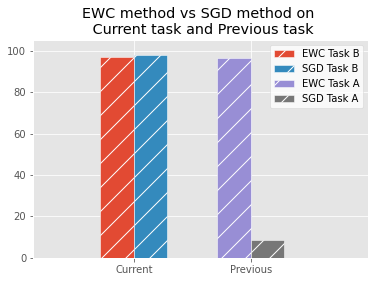

In [48]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

In [ ]:
# unlike overlapped labels where swapping task A and B(randomised) didnt made any difference, extended labels forgot random labels completely after training with mnist in sgd

## With mnist first and fmnist as sequential task

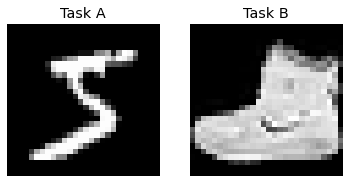

In [51]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))


#MNIST for task B

(x_train1, y_train1), (x_test1, y_test1) = fashion_mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()


In [52]:
from tensorflow import keras
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)

In [53]:
print(y_train1[2])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [54]:
import numpy as np

for i in range(10):
    y_train = np.hstack((y_train, np.zeros((len(y_train),1))))
    y_test = np.hstack((y_test, np.zeros((len(y_test),1))))
    y_train1 = np.hstack((y_train1, np.zeros((len(y_train1),1))))
    y_test1 = np.hstack((y_test1, np.zeros((len(y_test1),1))))

In [55]:
print(y_train1[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [56]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(20, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('MNISTA.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
58600/60000 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8988

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 34us/sample - loss: 0.3685 - accuracy: 0.8999 - val_loss: 0.1967 - val_accuracy: 0.9450
Epoch 2/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.1665 - accuracy: 0.9520 - val_loss: 0.1387 - val_accuracy: 0.9601
Epoch 3/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.1184 - accuracy: 0.9659 - val_loss: 0.1065 - val_accuracy: 0.9691
Epoch 4/10
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0899 - accuracy: 0.9745 - val_loss: 0.0934 - val_accuracy: 0.9730
Epoch 5/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0713 - accuracy: 0.9794 - val_loss: 0.0882 - val_accuracy: 0.9750
Epoch 6/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0594 - accuracy: 0.9830 - val_loss: 0.0827 - val_accuracy: 0.9763
Epoch 7/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0487 - accuracy: 0.9861 - val_loss

In [57]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3821533/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [58]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(20, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/sample - loss: 1.5769 - accuracy: 0.6861 - val_loss: 0.8368 - val_accuracy: 0.7624
Epoch 2/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.6593 - accuracy: 0.8052 - val_loss: 0.6530 - val_accuracy: 0.7957
Epoch 3/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.5480 - accuracy: 0.8307 - val_loss: 0.5697 - val_accuracy: 0.8221
Epoch 4/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.4995 - accuracy: 0.8409 - val_loss: 0.5389 - val_accuracy: 0.8309
Epoch 5/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.4626 - accuracy: 0.8492 - val_loss: 0.5157 - val_accuracy: 0.8360
Epoch 6/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.4407 - accuracy: 0.8559 - val_loss: 0.5069 - val_accuracy: 0.8366
Epoch 7/10
60000/60000 [==============================] 

In [59]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(20, activation='softmax'))
model_NoP_B.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 34us/sample - loss: 0.9512 - accuracy: 0.7480 - val_loss: 0.5249 - val_accuracy: 0.8153
Epoch 2/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.4314 - accuracy: 0.8487 - val_loss: 0.4403 - val_accuracy: 0.8451
Epoch 3/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.3762 - accuracy: 0.8670 - val_loss: 0.4033 - val_accuracy: 0.8579
Epoch 4/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3425 - accuracy: 0.8783 - val_loss: 0.3740 - val_accuracy: 0.8669
Epoch 5/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.3193 - accuracy: 0.8852 - val_loss: 0.3634 - val_accuracy: 0.8680
Epoch 6/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3043 - accuracy: 0.8904 - val_loss: 0.3634 - val_accuracy: 0.8697
Epoch 7/10
60000/60000 [==============================] 

In [60]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 98.01%
Task B EWC method penalty Accuracy: 85.41%
Task B SGD method Accuracy: 88.02%
Task A EWC method penalty Accuracy: 90.20%
Task A SGD method Accuracy: 37.24%


/tmp/ipykernel_3821533/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

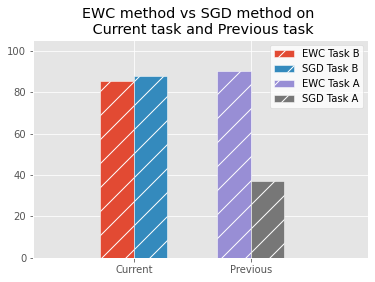

In [77]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

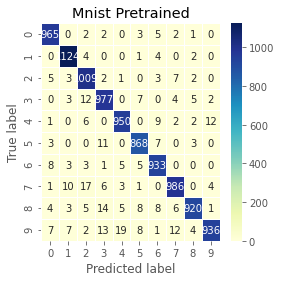

In [70]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_arg = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


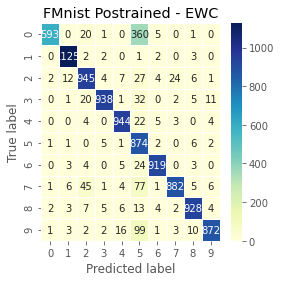

In [71]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
y_test1_arg = np.argmax(y_test1, axis=-1)
y_pred = np.argmax(model_ewcB.predict(x_test1), axis=-1)
cm = confusion_matrix(y_test1_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

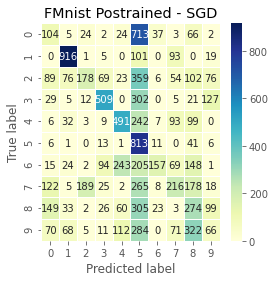

In [73]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_test1_arg = np.argmax(y_test1, axis=-1)
y_pred = np.argmax( model_NoP_B.predict(x_test1), axis=-1)
cm = confusion_matrix(y_test1_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

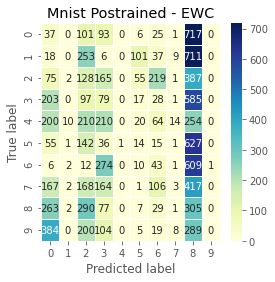

In [74]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_arg = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model_ewcB.predict(x_test), axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

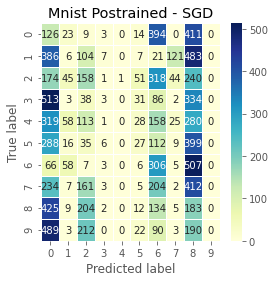

In [76]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_test_arg = np.argmax(y_test, axis=-1)
y_pred = np.argmax( model_NoP_B.predict(x_test), axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## With fmnist first and mnist as sequential task

In [62]:
# swap task A and B

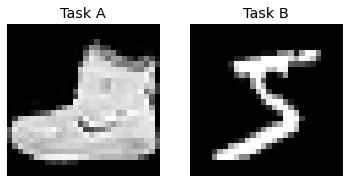

In [78]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))


#MNIST for task B

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [79]:
from tensorflow import keras
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)

In [80]:
print(y_train1[2])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [81]:
import numpy as np

for i in range(10):
    y_train = np.hstack((y_train, np.zeros((len(y_train),1))))
    y_test = np.hstack((y_test, np.zeros((len(y_test),1))))
    y_train1 = np.hstack((y_train1, np.zeros((len(y_train1),1))))
    y_test1 = np.hstack((y_test1, np.zeros((len(y_test1),1))))

In [82]:
print(y_train1[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [83]:
# Task A training and save the prior weights for the next Task
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(20, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('randMNISTA.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59800/60000 [============================>.] - ETA: 0s - loss: 0.5590 - accuracy: 0.8088

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 2s 35us/sample - loss: 0.5586 - accuracy: 0.8090 - val_loss: 0.4516 - val_accuracy: 0.8406
Epoch 2/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.4028 - accuracy: 0.8580 - val_loss: 0.4097 - val_accuracy: 0.8566
Epoch 3/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.3654 - accuracy: 0.8703 - val_loss: 0.3843 - val_accuracy: 0.8613
Epoch 4/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3398 - accuracy: 0.8788 - val_loss: 0.3801 - val_accuracy: 0.8608
Epoch 5/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3206 - accuracy: 0.8840 - val_loss: 0.3681 - val_accuracy: 0.8709
Epoch 6/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3058 - accuracy: 0.8895 - val_loss: 0.3536 - val_accuracy: 0.8721
Epoch 7/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.2945 - accuracy: 0.8925 - val_loss

In [84]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3821533/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [85]:
# Task B EWC training
model_ewcB = Sequential()
model_ewcB.add(Dense(128, activation='relu', input_dim=784, kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])))
model_ewcB.add(Dense(20, activation='softmax', kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])))
model_ewcB.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/sample - loss: 971.6004 - accuracy: 0.9384 - val_loss: 372.8298 - val_accuracy: 0.9229
Epoch 2/10
60000/60000 [==============================] - 2s 31us/sample - loss: 194.1511 - accuracy: 0.9340 - val_loss: 83.2794 - val_accuracy: 0.9378
Epoch 3/10
60000/60000 [==============================] - 2s 32us/sample - loss: 40.9819 - accuracy: 0.9422 - val_loss: 14.9660 - val_accuracy: 0.9427
Epoch 4/10
60000/60000 [==============================] - 2s 31us/sample - loss: 6.3765 - accuracy: 0.9471 - val_loss: 1.7630 - val_accuracy: 0.9481
Epoch 5/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.7080 - accuracy: 0.9512 - val_loss: 0.2817 - val_accuracy: 0.9492
Epoch 6/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1942 - accuracy: 0.9545 - val_loss: 0.2016 - val_accuracy: 0.9505
Epoch 7/10
60000/60000 [=======================

In [86]:
# Task B no penalty training
model_NoP_B = Sequential()
model_NoP_B.add(Dense(128, activation='relu', input_dim=784))
model_NoP_B.add(Dense(20, activation='softmax'))
model_NoP_B.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.0695 - val_accuracy: 0.9798
Epoch 2/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.0772 - val_accuracy: 0.9791
Epoch 3/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.0715 - val_accuracy: 0.9803
Epoch 4/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0151 - accuracy: 0.9962 - val_loss: 0.0760 - val_accuracy: 0.9800
Epoch 5/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.0764 - val_accuracy: 0.9800
Epoch 6/10
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0106 - accuracy: 0.9977 - val_loss: 0.0778 - val_accuracy: 0.9793
Epoch 7/10
60000/60000 [==============================] 

In [87]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 88.19%
Task B EWC method penalty Accuracy: 95.43%
Task B SGD method Accuracy: 97.78%
Task A EWC method penalty Accuracy: 16.69%
Task A SGD method Accuracy: 11.05%


/tmp/ipykernel_3821533/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3821533/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

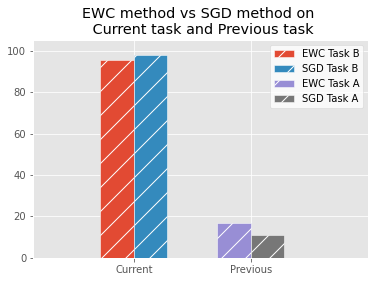

In [88]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

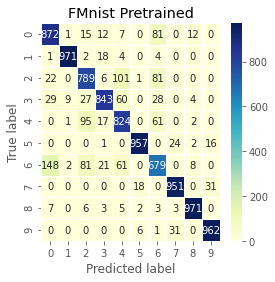

In [91]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model.predict(x_test), axis=-1)
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


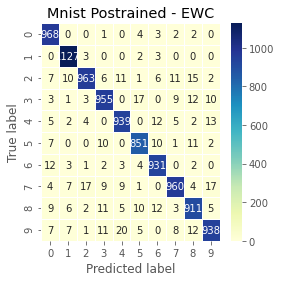

In [93]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test1), axis=-1)
cm = confusion_matrix(np.argmax(y_test1, axis=-1), y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


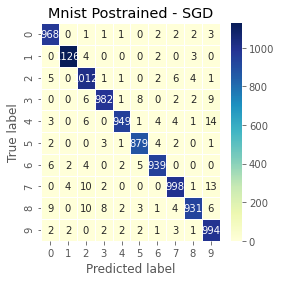

In [94]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test1), axis=-1)
cm = confusion_matrix(np.argmax(y_test1, axis=-1), y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

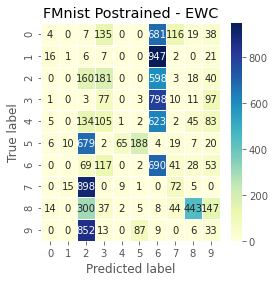

In [95]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test), axis=-1)
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

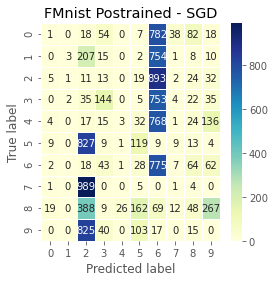

In [96]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test), axis=-1)
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# EWC is ineffective when network is forced to forget i.e. the zero labels unlearns everything